## Requirements

In [1]:
pip install pytorch_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.9 MB/s eta 0:00:00


In [2]:
pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.4 MB/s eta 0:00:00


In [3]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.5 MB/s eta 0:00:00


In [162]:
import csv
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import f1_score
import random
from collections import defaultdict
random.seed(42)
from __future__ import absolute_import, division, print_function
import glob
import logging
import os
import numpy as np
import torch
from pytorch_transformers import AdamW, WarmupLinearSchedule
from pytorch_transformers import (WEIGHTS_NAME, BertConfig,
                                  BertForSequenceClassification, BertTokenizer,)
# from tensorboardX import SummaryWriter
from torch.nn.functional import softmax
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.utils.data.distributed import DistributedSampler
from tqdm.auto import tqdm
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import pipeline

logger = logging.getLogger(__name__)


MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizer),
}


## File-handling

In [6]:
from google.colab import drive
drive.mount('/content/drive')

train_tsv = "/content/drive/My Drive/wiki_qa_test.tsv"
test_tsv = "/content/drive/My Drive/wiki_qa_train.tsv"
dev_tsv = "/content/drive/My Drive/wiki_qa_validation.tsv"

Mounted at /content/drive


## Functions

In [52]:
class InputFeatures:
    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


class InputExample:
    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def _truncate_seq_pair(tokens_a, tokens_b, max_length):

    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

class BERTSelProcessor:
    def get_train_examples(self, tsv_path):
        return self._create_examples_from_files("train", tsv_path)

    def get_dev_examples(self, tsv_path):
        return self._create_examples_from_files("dev", tsv_path)

    @staticmethod
    def get_labels():
        return ["0", "1"]

    @staticmethod
    def _create_examples_from_files(set_type, tsv_path):
        examples = []
        questions = {}  # Dictionary to organize answers based on their question

        with open(tsv_path, 'r', encoding='utf-8', newline='') as f:
            reader = csv.reader(f, delimiter='\t')
            for row in reader:
                if len(row) >= 3:  # Assuming 3 columns in the TSV: question, answer, label
                    question = row[0]
                    answer = row[1]
                    label = row[2]

                    guid = f"example-{len(examples)}"
                    if question not in questions:
                        questions[question] = []

                    new_example = InputExample(guid=guid, text_a=question, text_b=answer, label=label)
                    questions[question].append(new_example)

        # Create pairs of positive and negative examples for each question
        for question, examples_list in questions.items():
            positive_examples = [ex for ex in examples_list if ex.label == '1']
            negative_examples = [ex for ex in examples_list if ex.label == '0']

            # Pair each positive example with each negative example for the same question
            for pos_example in positive_examples:
                for neg_example in negative_examples:
                    examples.append((pos_example, neg_example))

        return examples


In [12]:
def convert_examples_to_features(examples, label_list, max_seq_length,
                                 tokenizer, output_mode,
                                 cls_token_at_end=False, pad_on_left=False,
                                 cls_token='[CLS]', sep_token='[SEP]', pad_token=0,
                                 sequence_a_segment_id=0, sequence_b_segment_id=1,
                                 cls_token_segment_id=1, pad_token_segment_id=0,
                                 mask_padding_with_zero=True):
    label_map = {label: i for i, label in enumerate(label_list)}

    features = []
    for example in examples:
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]

        tokens = tokens_a + [sep_token]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if tokens_b:
            tokens += tokens_b + [sep_token]
            segment_ids += [sequence_b_segment_id] * (len(tokens_b) + 1)

        if cls_token_at_end:
            tokens = tokens + [cls_token]
            segment_ids = segment_ids + [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
        else:
            input_ids = input_ids + ([pad_token] * padding_length)
            input_mask = input_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
            segment_ids = segment_ids + ([pad_token_segment_id] * padding_length)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        if output_mode == "classification":
            label_id = label_map[example.label]
        features.append(
            InputFeatures(input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids, label_id=label_id))

    return features

## Data Handling

In [10]:
task_name = "BERTSel"
max_seq_length = 128
model_name = "bert"
processor = BERTSelProcessor
output_mode = "classification"
label_list = processor.get_labels()
num_labels = len(label_list)

config_class, model_class, tokenizer_class = MODEL_CLASSES['bert']
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', return_dict=True)

config = BertConfig
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# model = TFBertModel.from_pretrained("bert-base-uncased")
# model = BertTokenizer

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
processor = BERTSelProcessor()
output_mode = "classification"
pair_examples = processor.get_train_examples(train_tsv)
print(len(pair_examples))

2467


In [54]:
processor = BERTSelProcessor()
output_mode = "classification"
pair_examples = processor.get_train_examples(train_tsv)
print("Pair Examples:", pair_examples[:5])  # Print a few examples to check data loading

positive_examples = []
negative_examples = []
for positive, negative in pair_examples:
    positive_examples.append(positive)
    negative_examples.append(negative)

print("Positive Examples:", len(positive_examples))  # Check the number of positive examples
print("Negative Examples:", len(negative_examples))  # Check the number of negative examples
print(len(pair_examples))

Pair Examples: [(<__main__.InputExample object at 0x7c7bc184f730>, <__main__.InputExample object at 0x7c7bc25ca980>), (<__main__.InputExample object at 0x7c7bc184f730>, <__main__.InputExample object at 0x7c7bc17e7dc0>), (<__main__.InputExample object at 0x7c7bc184f730>, <__main__.InputExample object at 0x7c7bc17e7e50>), (<__main__.InputExample object at 0x7c7bc184f730>, <__main__.InputExample object at 0x7c7bc17e7eb0>), (<__main__.InputExample object at 0x7c7bc184f730>, <__main__.InputExample object at 0x7c7bc17e7f10>)]
Positive Examples: 2467
Negative Examples: 2467
2467


In [90]:
def load_and_cache_examples(task, tokenizer, evaluate=False):
    processor = BERTSelProcessor()
    output_mode = "classification"

    data_dir = "/content/drive/My Drive/"

    label_list = processor.get_labels()
    pair_examples = processor.get_dev_examples(test_tsv) if evaluate \
        else processor.get_train_examples(train_tsv)

    positive_examples = []
    negative_examples = []
    for postive, negative in pair_examples:
        positive_examples.append(postive)
        negative_examples.append(negative)

    print(pair_examples[1])
    def _get_features(examples, tokenizer):
        return convert_examples_to_features(examples, label_list, max_seq_length, tokenizer, output_mode,
                                                cls_token_at_end=False,
                                                # xlnet has a cls token at the end
                                                cls_token=BertTokenizer.cls_token,
                                                sep_token=BertTokenizer.sep_token,
                                                cls_token_segment_id=1,
                                                pad_on_left=False,
                                                # pad on the left for xlnet
                                                pad_token_segment_id= 0)

    features = zip(_get_features(positive_examples, tokenizer), _get_features(negative_examples, tokenizer))

    # Convert to Tensors and build dataset
    pos_input_ids = []
    pos_input_mask = []
    pos_segment_ids = []
    neg_input_ids = []
    neg_input_mask = []
    neg_segment_ids = []
    for postive, negative in features:
        pos_input_ids.append(postive.input_ids)
        pos_input_mask.append(postive.input_mask)
        pos_segment_ids.append(postive.segment_ids)

        neg_input_ids.append(negative.input_ids)
        neg_input_mask.append(negative.input_mask)
        neg_segment_ids.append(negative.segment_ids)

    temp = [pos_input_ids, pos_input_mask, pos_segment_ids, [1] * len(pos_input_ids),
            neg_input_ids, neg_input_mask, neg_segment_ids, [0] * len(pos_input_ids)]
    dataset = TensorDataset(*[torch.tensor(l, dtype=torch.long) for l in temp])

    return dataset




In [56]:
train_dataset = load_and_cache_examples(task_name, tokenizer, evaluate=False)

(<__main__.InputExample object at 0x7c7bc2236140>, <__main__.InputExample object at 0x7c7bc2235600>)


In [57]:
# Fetch the first feature from the dataset
test_feature = train_dataset[333]  # Fetching the first feature

# Printing out the feature information
# print("test:", test_feature)
print("Input IDs:", test_feature[0])  # Assuming input IDs are at index 0
print("Input Mask:", test_feature[1])  # Assuming input mask is at index 1
print("Segment IDs:", test_feature[2])  # Assuming segment IDs are at index 2
print("Label:", test_feature[3])  # Assuming label is at index 3


Input IDs: tensor([  100,  2054,  2515,  2529, 18047,  8676,  1997,  1029,   100,  1999,
         4286,  1010, 20603,  8331,  3397,  2195,  6177,  4661, 18047, 10610,
         6844,  2050,  1024,  4013,  2618,  4747, 21252,  1998,  2060, 16285,
         2004,  2092,  2004, 10424, 14194, 22282,  2024,  3787,  1997, 20603,
         8331,  2029,  5326,  1996,  7691,  1997, 18047, 10610,  6844,  2050,
         1998,  3073,  1037,  5396,  2083,  2029,  2027,  2064,  2693,  2030,
         1000,  9880,  1000,  1012,   100,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,    

## Model

In [59]:
train_batch_size = 8
local_rank = -1
max_steps = -1
gradient_accumulation_steps = 1
num_train_epochs = 3.0
weight_decay = 0.0
learning_rate = 5e-5
adam_epsilon = 1e-8
per_gpu_train_batch_size = 8
per_gpu_eval_batch_size = 8
max_grad_norm = 1.0
warmup_steps = 0
model_type = 'bert'
logging_steps = 50
save_steps = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
evaluate_during_training = 'store_true'
do_lower_case = 'store_true'
do_eval = 'store_true'
do_train = 'store_true'
output_dir =  "/content/drive/My Drive/allpairs"


In [60]:
def simple_accuracy(preds, labels):
    return (preds == labels).mean()


def acc_and_f1(preds, labels):
    acc = simple_accuracy(preds, labels)
    f1 = f1_score(y_true=labels, y_pred=preds)
    return {
        "acc": acc,
        "f1": f1,
        "acc_and_f1": (acc + f1) / 2,
    }



def evaluate( model, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_task_names = (task_name,)
    eval_outputs_dirs = (output_dir,)

    results = {}
    for eval_task, eval_output_dir in zip(eval_task_names, eval_outputs_dirs):
        eval_dataset = load_and_cache_examples(eval_task, tokenizer, evaluate=True)


        eval_batch_size = per_gpu_eval_batch_size * max(1, n_gpu)
        eval_sampler = SequentialSampler(eval_dataset) if local_rank == -1 else DistributedSampler(eval_dataset)
        eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=eval_batch_size)

        eval_loss = 0.0
        nb_eval_steps = 0
        preds = None
        out_label_ids = None
        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            model.eval()
            batch = tuple(t.to(device) for t in batch)[:4]

            with torch.no_grad():
                inputs = {'input_ids': batch[0],
                          'attention_mask': batch[1],
                          'token_type_ids': batch[2] if model_type in ['bert', 'xlnet'] else None,
                          'labels': batch[3]}
                outputs = model(**inputs)
                tmp_eval_loss, logits = outputs[:2]

                eval_loss += tmp_eval_loss.mean().item()
            nb_eval_steps += 1
            if preds is None:
                preds = logits.detach().cpu().numpy()
                out_label_ids = inputs['labels'].detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

        if output_mode == "classification":
            preds = np.argmax(preds, axis=1)

        result = acc_and_f1(preds, out_label_ids)
        results.update(result)
    return results


In [61]:
import time
import matplotlib.pyplot as plt


def train(train_dataset, model, tokenizer):
    train_batch_size = 8
    local_rank = -1
    max_steps = -1
    gradient_accumulation_steps = 1
    num_train_epochs = 3.0
    weight_decay = 0.0
    learning_rate = 5e-5
    adam_epsilon = 1e-8
    per_gpu_train_batch_size = 8
    per_gpu_eval_batch_size = 8
    max_grad_norm = 1.0
    warmup_steps = 0
    model_type = 'bert'
    logging_steps = 50
    save_steps = 50
    output_dir =  "/content/drive/My Drive/proj"

    # if -1 in [-1, 0]:
    #     tb_writer = SummaryWriter()

    train_sampler = RandomSampler(train_dataset) if local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=train_batch_size)

    if max_steps > 0:
        t_total = max_steps
        num_train_epochs = max_steps // (len(train_dataloader) // gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // gradient_accumulation_steps * num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
    scheduler = WarmupLinearSchedule(optimizer, warmup_steps=warmup_steps, t_total=t_total)



    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = range(int(num_train_epochs))

    def _get_output(_batch):
        inputs = {'input_ids': _batch[0],
                  'attention_mask': _batch[1],
                  'token_type_ids': _batch[2] if model_type in ['bert', 'xlnet'] else None,
                  'labels': _batch[3]}
        return model(**inputs)



    train_losses = []
    runtimes = []

    start_time = time.time()  # Record the start time



    for e in train_iterator:
        epoch_start_time = time.time()  # Record the start time of the epoch
        epoch_iterator = tqdm(train_dataloader, desc=f"Epoch {e + 1}/{int(num_train_epochs)}",
                              disable=local_rank not in [-1, 0])

        for step, batch in enumerate(epoch_iterator):

            step_start_time = time.time()
            model.train()
            batch = tuple(t.to(device) for t in batch)
            positive_scores = softmax(_get_output(batch[:4])[1], dim=1)[:, 1]
            negative_scores = softmax(_get_output(batch[4:])[1], dim=1)[:, 1]

            cross_entropy_loss = -torch.log(positive_scores) - torch.log(1 - negative_scores)
            hinge_loss = torch.max(torch.tensor(0, dtype=torch.float).to(device),
                                   1 - positive_scores + negative_scores)
            loss = (0.5 * cross_entropy_loss + 0.5 * hinge_loss).sum()

            # if args.n_gpu > 1:
            loss = loss.mean()  # mean() to average on multi-gpu parallel training

            if gradient_accumulation_steps > 1:
                loss = loss / gradient_accumulation_steps

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            tr_loss += loss.item()

            if (step + 1) % gradient_accumulation_steps == 0:
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                # if local_rank in [-1, 0] and logging_steps > 0 and global_step % logging_steps == 0:
                #     # Log metrics
                #     if local_rank == -1 and evaluate_during_training:
                #         # Only evaluate when single GPU otherwise metrics may not average well
                #         results = evaluate( model, tokenizer)
                #         for key, value in results.items():
                #             tb_writer.add_scalar('eval_{}'.format(key), value, global_step)
                #     tb_writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
                #     tb_writer.add_scalar('loss', (tr_loss - logging_loss) / logging_steps, global_step)
                #     logging_loss = tr_loss

                # if local_rank in [-1, 0] and save_steps > 0 and global_step % save_steps == 0:
                #     # Save model checkpoint
                #     output_dir = os.path.join(output_dir, 'checkpoint-{}'.format(global_step))
                #     if not os.path.exists(output_dir):
                #         os.makedirs(output_dir)
                #     model_to_save = model.module if hasattr(model, 'module') else model
                #     model_to_save.save_pretrained(output_dir)
                #     torch.save(model_to_save, os.path.join(output_dir, 'training_args.bin'))
                #     logger.info("Saving model checkpoint to %s", output_dir)

            if 0 < max_steps < global_step:
                epoch_iterator.close()
                break

            # Append training loss to the list
            train_losses.append((tr_loss - logging_loss) / logging_steps)

            # Record the runtime for this step
            step_end_time = time.time()
            step_runtime = step_end_time - step_start_time
            runtimes.append(step_runtime)

            # Validation loss calculation (assuming a function `calculate_validation_loss()` exists)
            # validation_loss = calculate_validation_loss(model, tokenizer)
            # validation_losses.append(validation_loss)


        if 0 < max_steps < global_step:
            train_iterator.close()
            break

        epoch_end_time = time.time()  # Record the end time of the epoch
        print(f"Epoch {e + 1} Runtime: {epoch_end_time - epoch_start_time} seconds")



    # if local_rank in [-1, 0]:
    #     tb_writer.close()




    # Print the total runtime
    end_time = time.time()
    total_runtime = end_time - start_time
    print(f"Total Runtime: {total_runtime} seconds")

    # Plotting the loss graph
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training')
    plt.legend()
    plt.show()

    # Plotting the runtime graph
    plt.figure(figsize=(10, 5))
    plt.plot(runtimes, label='Step Runtimes')
    plt.xlabel('Steps')
    plt.ylabel('Time (seconds)')
    plt.title('Step Runtimes')
    plt.legend()
    plt.show()


    return global_step, tr_loss / global_step

In [62]:
if next(model.parameters()).is_cuda:
    model.to('cpu')
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Move the tensors to the same device as the model
train_sampler = RandomSampler(train_dataset) if local_rank == -1 else DistributedSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=train_batch_size)



Epoch 1/3:   0%|          | 0/309 [00:00<?, ?it/s]

(<__main__.InputExample object at 0x7c7bb9617fd0>, <__main__.InputExample object at 0x7c7bb96145b0>)


Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:261: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


(<__main__.InputExample object at 0x7c7bb7af9b70>, <__main__.InputExample object at 0x7c7bb7afa680>)


Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:261: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


(<__main__.InputExample object at 0x7c7bb795a7a0>, <__main__.InputExample object at 0x7c7bb795b160>)


Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:261: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


(<__main__.InputExample object at 0x7c7bb7a9d9f0>, <__main__.InputExample object at 0x7c7bb7a9efe0>)


Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:261: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


(<__main__.InputExample object at 0x7c7bb79aada0>, <__main__.InputExample object at 0x7c7bb79ab880>)


Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:261: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


(<__main__.InputExample object at 0x7c7bb79c2b60>, <__main__.InputExample object at 0x7c7bb79c3fd0>)


Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:261: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 1 Runtime: 198.39050769805908 seconds


Epoch 2/3:   0%|          | 0/309 [00:00<?, ?it/s]

(<__main__.InputExample object at 0x7c7bb7980490>, <__main__.InputExample object at 0x7c7bb7983610>)


Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:261: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


(<__main__.InputExample object at 0x7c7bb6800760>, <__main__.InputExample object at 0x7c7bb6801210>)


Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:261: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


(<__main__.InputExample object at 0x7c7bb68014b0>, <__main__.InputExample object at 0x7c7bb6802cb0>)


Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:261: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


(<__main__.InputExample object at 0x7c7bb7ad9bd0>, <__main__.InputExample object at 0x7c7bb7ad9ab0>)


Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:261: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


(<__main__.InputExample object at 0x7c7bb6827670>, <__main__.InputExample object at 0x7c7bb68259f0>)


Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:261: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


(<__main__.InputExample object at 0x7c7bb7912770>, <__main__.InputExample object at 0x7c7bb7910370>)


Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:261: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 2 Runtime: 204.52642154693604 seconds


Epoch 3/3:   0%|          | 0/309 [00:00<?, ?it/s]

(<__main__.InputExample object at 0x7c7bb7a364a0>, <__main__.InputExample object at 0x7c7bb7a37880>)


Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:261: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


(<__main__.InputExample object at 0x7c7bb84e5a80>, <__main__.InputExample object at 0x7c7bb84e7040>)


Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:261: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


(<__main__.InputExample object at 0x7c7bb7a2be20>, <__main__.InputExample object at 0x7c7bb7a28d90>)


Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:261: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


(<__main__.InputExample object at 0x7c7bb7a9f7f0>, <__main__.InputExample object at 0x7c7bb7a9ce50>)


Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:261: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


(<__main__.InputExample object at 0x7c7bb6803fa0>, <__main__.InputExample object at 0x7c7bb6800730>)


Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:261: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


(<__main__.InputExample object at 0x7c7bb790b940>, <__main__.InputExample object at 0x7c7bb790bf40>)


Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:261: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 3 Runtime: 192.77803015708923 seconds
Total Runtime: 595.6977174282074 seconds


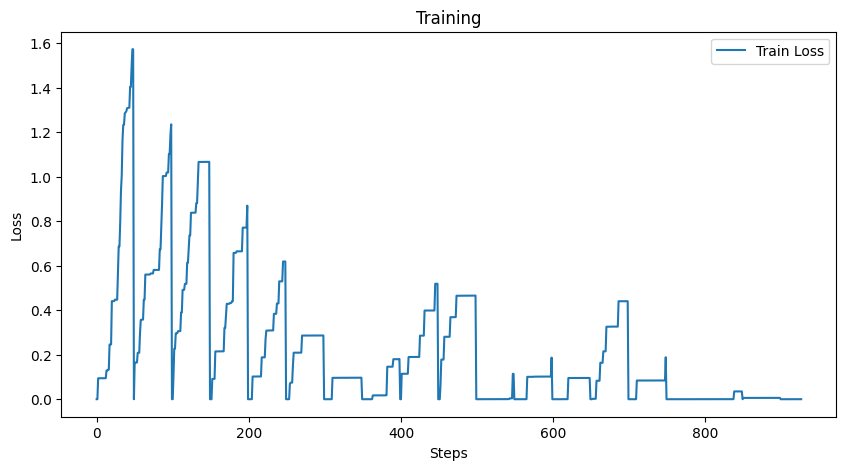

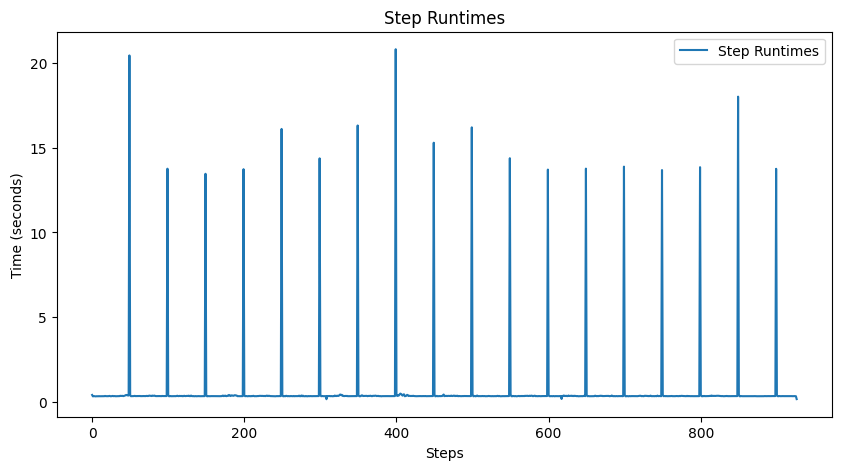

In [64]:
global_step, tr_loss = train(train_dataset, model, tokenizer)

In [147]:
print("global_step = ", global_step)
print("average loss = ", tr_loss)

global_step =  927
average loss =  0.44225231727358816


## saving model

In [66]:
if do_train and (local_rank == -1 or torch.distributed.get_rank() == 0):
        # Create output directory if needed
    if not os.path.exists(output_dir) and local_rank in [-1, 0]:
        os.makedirs(output_dir)

    logger.info("Saving model checkpoint to %s", output_dir)
        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
    model_to_save = model.module if hasattr(model,
                                                'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

        # Good practice: save your training arguments together with the trained model
    torch.save(model_to_save, os.path.join(output_dir, 'training_args.bin'))

        # Load a trained model and vocabulary that you have fine-tuned
    model = model_class.from_pretrained(output_dir)
    tokenizer = tokenizer_class.from_pretrained(output_dir)
    model.to(device)


## test2

In [123]:
test_examples = []

with open(test_tsv, 'r', encoding='utf-8', newline='') as f:
    reader = csv.reader(f, delimiter='\t')
    next(reader)  # Skip header if exists
    for row in reader:
        question = row[0]
        answer = row[1]
        label = int(row[2])  # Assuming labels are integers

        test_examples.append((question, answer, label))



In [130]:
from tqdm import tqdm  # Import tqdm for progress tracking

# Function to generate predictions and labels
def get_predictions_and_labels(model, tokenizer, examples):
    per_qn_inputs = {}
    num_examples = len(examples)

    for i, (question, answer, label) in enumerate(tqdm(examples, desc="Processing", total=num_examples)):
        if question not in per_qn_inputs:
            per_qn_inputs[question] = {"labels": [], "predictions": []}

        encoded_dict = tokenizer.encode_plus(
            question,
            answer,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            return_tensors='pt',
            return_attention_mask=True,
            return_token_type_ids=True,
            truncation=True
        )

        input_ids = encoded_dict['input_ids']
        attention_mask = encoded_dict['attention_mask']
        token_type_ids = encoded_dict['token_type_ids']

        # Set the device (GPU or CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Move the model to the selected device
        model.to(device)

        # Process the input tensors to make sure they are on the same device
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        # Then, execute the model with these tensors
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        probabilities = torch.softmax(outputs.logits, dim=1)
        predicted_label = torch.argmax(probabilities, dim=1).tolist()[0]

        per_qn_inputs[question]["labels"].append(label)
        per_qn_inputs[question]["predictions"].append(probabilities[0][1].item())

    return per_qn_inputs


In [131]:
# Get predictions and labels for each query
predictions_labels = get_predictions_and_labels(model, tokenizer, test_examples)


Processing: 100%|██████████| 8672/8672 [02:24<00:00, 59.93it/s]


In [132]:
# Displaying predictions and labels per query
for query, data in predictions_labels.items():
    print(f"Query: {query}")
    print(f"Labels: {data['labels']}")
    print(f"Predictions: {data['predictions']}")


Query: how are glacier caves formed?
Labels: [0, 0, 0, 1, 0]
Predictions: [4.864059155806899e-05, 1.6808606233098544e-05, 2.0710122043965384e-05, 0.9996020197868347, 0.00010408660455141217]
Query: how much is 1 tablespoon of water
Labels: [1, 0, 0, 0, 0, 0, 0, 0, 1, 1]
Predictions: [1.5553519915556535e-05, 1.7042242689058185e-05, 0.9917471408843994, 0.9991355538368225, 3.128319076495245e-05, 0.10827578604221344, 6.008006675983779e-05, 1.3537602171709295e-05, 0.0001604900899110362, 0.0012630317360162735]
Query: how much are the harry potter movies worth
Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Predictions: [0.9997362494468689, 0.212113618850708, 0.983806848526001, 0.0002704144280869514, 4.9511712859384716e-05, 0.0030990825034677982, 2.480310467944946e-05, 4.06802209909074e-05, 0.0015243944944813848, 5.2780116675421596e-05, 0.0001526016421848908, 0.00015721918316558003, 0.003726095659658313, 2.752513682935387e-05, 1.7633372408454306e-05]
Query: how a rocket engine works
Labe

In [155]:
# Define the file path in your Google Drive
file_path = '/content/drive/My Drive/predictions_labels.txt'

# Open the file in write mode and save the predictions and labels
with open(file_path, 'w') as file:
    for query, data in predictions_labels.items():
        file.write(f"Query: {query}\n")
        file.write(f"Labels: {data['labels']}\n")
        file.write(f"Predictions: {data['predictions']}\n")
        file.write("\n")  # Separating different queries



In [156]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import average_precision_score
import numpy as np

def compute_scores(predictions_labels):
    avg_prec_scores = []

    for qn in predictions_labels:
        labels = predictions_labels[qn]["labels"]
        predictions = predictions_labels[qn]["predictions"]

        if labels.count(1) == 0 or labels.count(0) == 0:
            continue

        labels = np.array(labels).reshape(-1, 1)
        predictions = np.array(predictions).reshape(-1, 1)

        avg_prec_scores.append(average_precision_score(labels, predictions))

        sorted_pred_label = np.argsort(predictions.flatten())[::-1]

        for j in range(len(sorted_pred_label)):
            row = sorted_pred_label[j]

    map_score = np.mean(avg_prec_scores)

    print("MAP Score: ", map_score)

    return {
        "mAP": map_score,
    }

scores = compute_scores(predictions_labels)

MAP Score:  0.660814420797355


In [158]:
def calculate_mrr(labels, predictions):
    # Find indexes where labels are 1
    relevant_indexes = [i for i, label in enumerate(labels) if label == 1]

    # Sort predictions' indexes based on prediction scores
    sorted_indexes = sorted(range(len(predictions)), key=lambda i: predictions[i], reverse=True)

    # Calculate MRR
    reciprocal_ranks = [1 / (sorted_indexes.index(idx) + 1) for idx in relevant_indexes if idx in sorted_indexes]
    if reciprocal_ranks:
        mrr = sum(reciprocal_ranks) / len(reciprocal_ranks)
        return mrr
    else:
        return 0  # If there are no relevant predictions

# Calculate MRR for each query
total_mrr = 0
queries_count = 0
for query, data in predictions_labels.items():
    labels = data['labels']
    predictions = data['predictions']
    mrr = calculate_mrr(labels, predictions)
    print(f"Query: {query}")
    print(f"Mean Reciprocal Rank (MMR): {mrr}\n")
    total_mrr += mrr
    queries_count += 1

if queries_count > 0:
    overall_mrr = total_mrr / queries_count
    print(f"Overall Mean Reciprocal Rank (MMR) across all queries: {overall_mrr}")
else:
    print("No queries found.")


Query: how are glacier caves formed?
Mean Reciprocal Rank (MMR): 1.0

Query: how much is 1 tablespoon of water
Mean Reciprocal Rank (MMR): 0.18703703703703703

Query: how much are the harry potter movies worth
Mean Reciprocal Rank (MMR): 0.07692307692307693

Query: how a rocket engine works
Mean Reciprocal Rank (MMR): 1.0

Query: how are cholera and typhus transmitted and prevented
Mean Reciprocal Rank (MMR): 0.5

Query: how did anne frank die
Mean Reciprocal Rank (MMR): 0.16666666666666666

Query: how are aircraft radial engines built
Mean Reciprocal Rank (MMR): 1.0

Query: how deep can be drill for deep underwater
Mean Reciprocal Rank (MMR): 1.0

Query: how old was monica lewinsky during the affair
Mean Reciprocal Rank (MMR): 1.0

Query: how long was frank sinatra famous
Mean Reciprocal Rank (MMR): 0.125

Query: how much is jk rowling worth
Mean Reciprocal Rank (MMR): 0.5

Query: how big is auburndale florida
Mean Reciprocal Rank (MMR): 0.5

Query: how old is kirk douglas, the actor?

In [160]:
# Write query details and MRR values to a text file
file_path = '/content/drive/My Drive/MMR_Results.txt'  # Specify the file path

with open(file_path, 'w') as file:
    total_mrr = 0
    queries_count = 0

    for query, data in predictions_labels.items():
        labels = data['labels']
        predictions = data['predictions']
        mrr = calculate_mrr(labels, predictions)
        file.write(f"Query: {query}\n")
        file.write(f"Mean Reciprocal Rank (MMR): {mrr}\n\n")
        total_mrr += mrr
        queries_count += 1

    if queries_count > 0:
        overall_mrr = total_mrr / queries_count
        file.write(f"Overall Mean Reciprocal Rank (MMR) across all queries: {overall_mrr}\n")
    else:
        file.write("No queries found.")

print(f"Results have been saved to: {file_path}")


Results have been saved to: /content/drive/My Drive/MMR_Results.txt
